In [2]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
import torch
from torch.nn import Linear, Sequential, ReLU, L1Loss, LSTM
from torch.optim import Adam, lr_scheduler
import numpy as np

from BaseNetwork import BaseNetwork

%load_ext autoreload
%autoreload 2

In [138]:
prev_timesteps = 6
prediction_steps = 6
batch_size = 25

train = MoviaBusDataset('../data/train', 
                        interpolation=True, 
                        prev_timesteps=prev_timesteps, 
                        max_future_time_steps=prediction_steps)

test = MoviaBusDataset('../data/test', 
                       interpolation=True, 
                       prev_timesteps=prev_timesteps, 
                       max_future_time_steps=prediction_steps)

In [139]:
train.normalize(individual_roads=True)
test.normalize(train.mean, train.std)

In [162]:
num_timesteps = (prev_timesteps + 1)
num_roads = train[0]['target'].size()[1]

class RNN(BaseNetwork):
    def __init__(self, num_layers=1):
        super(RNN, self).__init__()
        
        self.num_layers = num_layers
        
        self.lstm = LSTM(num_roads, num_roads, batch_first=True, num_layers=num_layers, dropout=0.4)
        
        self.activation = ReLU()
        
    def forward(self,x):
        #x : [batch_size, timesteps, wayids]
        
        n_batch = x.size()[0]
        hidden = (torch.randn(self.num_layers, n_batch, num_roads).cuda(),
                  torch.randn(self.num_layers, n_batch, num_roads).cuda())
        
        #Run model on previous timesteps
        for t_i in range(prev_timesteps):
            out, hidden = self.lstm(x[:,t_i,:].view(-1,1,num_roads),hidden)
        
        
           
        predictions = []
        #Use the model to predict several timesteps into the future
        for i in range(prediction_steps):
            
            out, hidden = self.lstm(out.view(-1,1,num_roads),hidden)
            prediction = out[:,0,:self.num_roads]
        
            predictions.append(prediction)
      
        return torch.stack(predictions,1)

net = RNN(num_layers=2)

optimizer_fun = lambda param : Adam(param, lr=1e-4, weight_decay=0)
scheduler_fun = lambda optim : lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)
criterion = L1Loss()

In [163]:
net.train_network(train, test,batch_size=batch_size, 
                  num_epochs=30,
                  optimizer_fun=optimizer_fun,
                  #scheduler_fun=scheduler_fun,
                  #shuffle=True,
                  criterion=criterion)

epoch =  0  train loss = 0.765   test loss = 0.789   output_std = 0.055
epoch =  2  train loss = 0.722   test loss = 0.757   output_std = 0.297
epoch =  4  train loss = 0.711   test loss = 0.751   output_std = 0.307
epoch =  6  train loss = 0.707   test loss = 0.748   output_std = 0.317
epoch =  8  train loss = 0.704   test loss = 0.747   output_std = 0.322
epoch = 10  train loss = 0.701   test loss = 0.746   output_std = 0.328
epoch = 12  train loss = 0.698   test loss = 0.745   output_std = 0.335
epoch = 14  train loss = 0.695   test loss = 0.745   output_std = 0.337
epoch = 16  train loss = 0.693   test loss = 0.745   output_std = 0.336
epoch = 18  train loss = 0.691   test loss = 0.745   output_std = 0.338
epoch = 20  train loss = 0.689   test loss = 0.744   output_std = 0.331
epoch = 22  train loss = 0.686   test loss = 0.745   output_std = 0.332
epoch = 24  train loss = 0.684   test loss = 0.745   output_std = 0.328
epoch = 26  train loss = 0.682   test loss = 0.745   output_std 

In [164]:
scores=[net.get_MAE_score(timestep=i) for i in range(1,prediction_steps+1)]
print(scores)
print(sum(scores)/len(scores))

[1.5967038869857788, 1.6012173891067505, 1.607107400894165, 1.6134065389633179, 1.6196292638778687, 1.6269384622573853]
1.6108338236808777


<IPython.core.display.Javascript object>


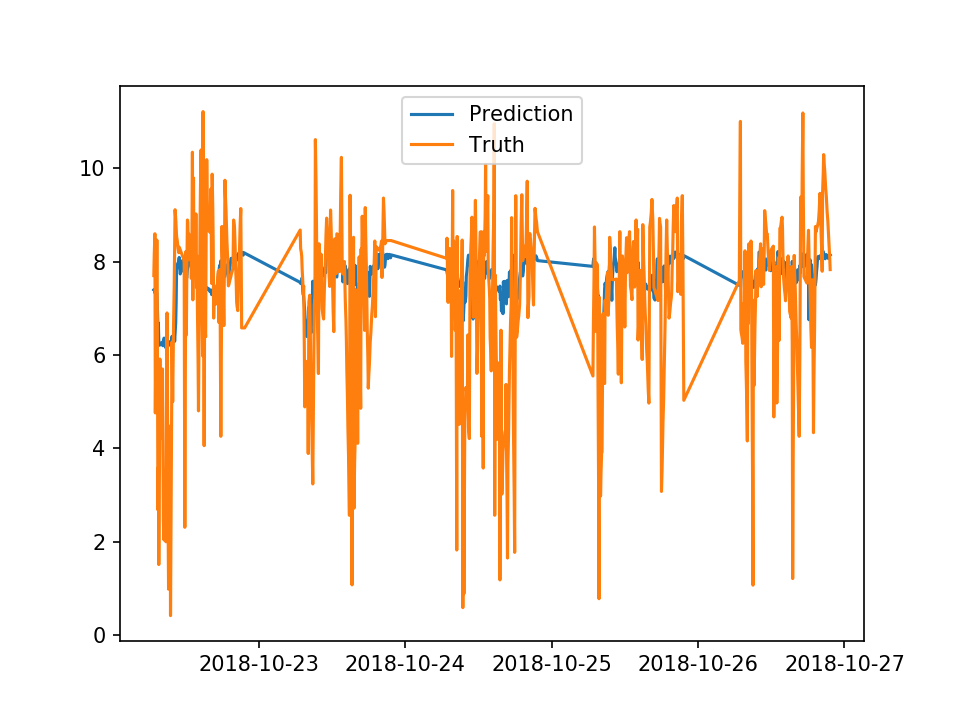

In [161]:
%matplotlib notebook

net.visualize_road(timesteps=3, road=9)

* 2 lstms
* indivual_road=True
* prev=6
* batch=25
* MAE=
[1.5938279628753662, 1.597127079963684, 1.6026233434677124, 1.6077381372451782, 1.6123509407043457, 1.6204285621643066]
1.6056826710700989


* 2 lstms
* indivual_road=False
* prev=6
* batch=100
* dropout = 0.3
* MAE=
[1.7410115003585815, 1.7417702674865723, 1.7435261011123657, 1.7450439929962158, 1.7469359636306763, 1.750575065612793]
1.7448104818662007


* 2 lstms
* Individual_road = True
* shuffle = False
* dropout = 0.3
* batch = 100
* lr = 1e-3
* MAE =
[1.617242693901062, 1.6234548091888428, 1.6301486492156982, 1.6363787651062012, 1.6430387496948242, 1.6502679586410522]
1.6334219376246135


* 2 lstms
* Individual_road = True
* shuffle = False
* dropout = 0
* batch = 100
* lr = 1e-3
* MAE =
[1.6509093046188354, 1.6624853610992432, 1.6709977388381958, 1.6783303022384644, 1.6858181953430176, 1.690630555152893]
1.673195242881775


* 2 lstms
* indivual_road=True
* prev=6
* batch=25
* epochs = 10
* MAE =
[1.6019037961959839, 1.6057021617889404, 1.610262393951416, 1.6147956848144531, 1.6188633441925049, 1.6230062246322632]
1.612422267595927


* 2 lstms
* indivual_road=True
* prev=6
* batch=25
* epochs = 3
* shuffle=True
* MAE = 
[1.6663920879364014, 1.6784924268722534, 1.6891628503799438, 1.6988554000854492, 1.7062901258468628, 1.713460087776184]
1.6921088298161824